# Import dependencies

In [1]:
import tensorflow as tf
import keras

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gc
import mlflow
from typing import Dict

# Prepare for mlflow

In [2]:
def get_and_set_experiment(
        experiment_name: str,
        artifact_path: str,
        tags: Dict[str, str]) -> str:
    """
    set the experiment for tracking using mlflow
    :param experiment_name:name of the experiment
    :param artifact_path: the name of the path that will save the artifacts
    :param tags: informative key: value format
    :return: experiment id
    """
    try:
        # try to create an experiment with the given name
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location=artifact_path,
            tags=tags
        )
    except:
        # if the experiment already exist, get the experiment id
        experiment_id = mlflow.get_experiment_by_name(
            name=experiment_name
        ).experiment_id
    finally:
        # finally, set the experiment using the experiment name
        mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id

### Setting the experiment and start the run

In [3]:
experiment_id = get_and_set_experiment(
    experiment_name='Cat Images Generator',
    artifact_path='artifacts',
    tags={
        'model type': 'Generative AI'
    }
)
experiment_id

'270657931257758153'

In [4]:
mlflow.start_run()

<ActiveRun: >

In [5]:
run_id  = mlflow.active_run().info.run_id
run_id

'6d5ec26eb32f456089142764ee67dfd0'

# Load the dataset

In [6]:
dataset = keras.utils.image_dataset_from_directory(
    './data/cats',
    label_mode=None,
    image_size=(64, 64),
    batch_size=mlflow.log_param('batch size', 32)
)
dataset = dataset.map(lambda x: x / 255.0)

Found 15747 files belonging to 1 classes.


# Plot a sample

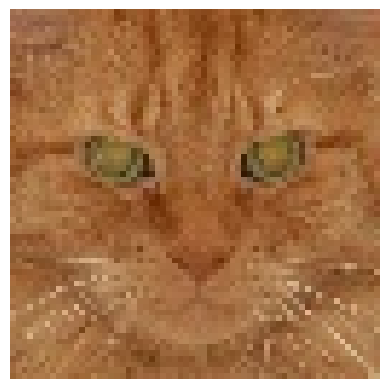

In [7]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Define discriminator

In [8]:
discriminator = keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(512, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Flatten(),
    # layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
], name="discriminator")

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                     

# Define generator

In [9]:
latent_dim = mlflow.log_param('laten dim', 128)

generator  = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    
    layers.Dense(4 * 4 * 1024),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Reshape((4, 4, 1024)),
    
    layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        20

# Custome training process

In [10]:
class GAN(keras.models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed = mlflow.log_param('GAN seed', 1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim),
            seed=self.seed
        )

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed
        )

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Log the output image periodicaly callbacks

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed = mlflow.log_param('Monitoring seed', 42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img ** 2, self.latent_dim), 
            seed=42
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        fig, axes = plt.subplots(self.num_img, self.num_img, figsize=(10, 10))
        axes = axes.flatten()
        
        # for i in range(self.num_img ** 2):
        for i, ax in enumerate(axes):
            img = keras.utils.array_to_img(generated_images[i])
            ax.imshow(img)
            ax.axis('off')

            mlflow.log_metric('discriminator loss', logs["d_loss"], step=epoch)
            mlflow.log_metric('generator loss', logs["g_loss"], step=epoch)
            mlflow.log_figure(fig, f"Generated Images/Epoch {epoch}.png")

            plt.close(fig)

# Initialize the models

In [12]:
gan = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
)


mlflow.log_param('discriminator optimizer', 'Adam')
mlflow.log_param('generator optimizer', 'Adam')

    
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=mlflow.log_param('discriminator learning rate', 0.0001)),
    g_optimizer=keras.optimizers.Adam(learning_rate=mlflow.log_param('generator learning rate', 0.0001)),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

### Begin the training process

In [13]:
epochs = mlflow.log_param('epochs', 50)

gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[GANMonitor(latent_dim=latent_dim)]
)

Epoch 1/50
493/493 [==============================] - 800s 1s/step - d_loss: 0.3497 - g_loss: 10.1280
Epoch 2/50
493/493 [==============================] - 852s 2s/step - d_loss: 0.5053 - g_loss: 7.0116
Epoch 3/50
493/493 [==============================] - 755s 2s/step - d_loss: 0.4670 - g_loss: 4.3033
Epoch 4/50
493/493 [==============================] - 593s 1s/step - d_loss: 0.6129 - g_loss: 6.5591
Epoch 5/50
493/493 [==============================] - 540s 1s/step - d_loss: 0.8763 - g_loss: 6.1741
Epoch 6/50
493/493 [==============================] - 494s 1s/step - d_loss: 0.6982 - g_loss: 4.7172
Epoch 7/50
493/493 [==============================] - 483s 980ms/step - d_loss: 0.5148 - g_loss: 1.9162
Epoch 8/50
493/493 [==============================] - 871s 2s/step - d_loss: 0.4168 - g_loss: 2.4550
Epoch 9/50
493/493 [==============================] - 878s 2s/step - d_loss: 0.3528 - g_loss: 4.0915
Epoch 10/50
493/493 [==============================] - 727s 1s/step - d_loss: 0.3276 - 

### Logging models

In [14]:
mlflow.tensorflow.log_model(gan.generator, 'generator')
mlflow.tensorflow.log_model(gan.discriminator, 'discriminator')

2024/08/10 08:48:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmp88m0fu4r\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmp88m0fu4r\model\data\model\assets
D:\UsingSpace\anaconda3\envs\tfgpu\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/10 08:48:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/10 08:48:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpxr03dtp2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpxr03dtp2\model\data\model\assets
2024/08/10 08:48:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [15]:
mlflow.end_run()

In [18]:
with mlflow.start_run(run_id="6d5ec26eb32f456089142764ee67dfd0") as runner:
    mlflow.tensorflow.log_model(gan.generator, 'gan')

2024/08/10 08:57:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpre7iio6s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpre7iio6s\model\data\model\assets
2024/08/10 08:57:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


# Deploy the model

In [2]:
import mlflow
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
num_noise = 128

model_uri = "runs:/6d5ec26eb32f456089142764ee67dfd0/gan"
gan = mlflow.tensorflow.load_model(
    model_uri=model_uri
)
gan.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        20

In [19]:
random_latent_vectors = tf.random.normal(
    shape=(1, num_noise)
)
random_latent_vectors

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-5.1885437e-02, -1.5818789e+00,  8.9957225e-01,  3.4991071e-01,
         6.4317971e-01, -3.4857759e-01, -2.5560455e+00, -8.3114856e-01,
        -1.0520260e-01, -1.1270260e+00,  1.5409416e+00, -3.7552106e-01,
         1.1883718e+00,  1.7312974e+00,  8.9742231e-01,  2.4082439e-01,
         1.0297160e+00,  3.8191715e-01, -1.3509548e+00,  5.3628546e-01,
         1.8922565e+00, -8.9568734e-01,  1.2701721e+00, -1.5507106e-03,
         2.2556862e-01, -1.9578296e+00,  2.2452055e-01,  4.5216754e-01,
        -8.4819812e-01, -1.9927672e-01, -6.4486963e-01, -1.8949769e-02,
         2.1926163e-01, -2.5810221e-02,  1.4584060e+00,  7.5712985e-01,
         7.9838663e-01,  7.7323657e-01,  1.0001602e+00, -1.3448805e+00,
        -2.2160450e-02, -2.9765981e-01,  7.4860889e-01,  8.9756131e-02,
        -1.0046691e+00,  9.4427747e-01,  2.1289396e+00,  1.7251382e+00,
         1.2602571e+00,  5.5989909e-01, -6.6925538e-01, -6.7070466e-01,
         9.735

In [20]:
gen_img = gan.predict(random_latent_vectors)
gen_img.shape

1/1 [==============================] - 0s 18ms/step


(1, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


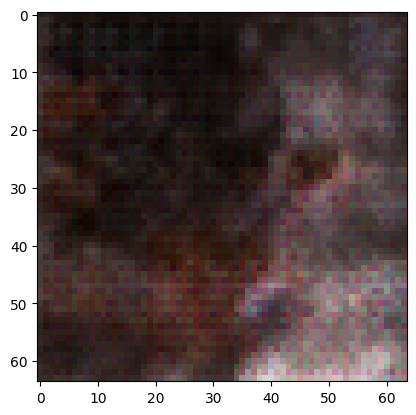

In [21]:
plt.imshow((gen_img[0] * 255).astype('int32'))